In [1]:
import pandas as pd
import numpy as np
import sqlite3

con=sqlite3.connect('../db/sp.db')
df = pd.read_sql_query('''SELECT * FROM sp WHERE "index" BETWEEN '2006-01-01' AND '2012-01-01'  ''', con)
con.close()
df.index = pd.to_datetime(df['index'], format='mixed')

In [2]:
print(df.head())

                                   index   Close  Volume
index                                                   
2006-01-02 17:00:02  2006-01-02 17:00:02  1255.5       1
2006-01-02 17:00:03  2006-01-02 17:00:03  1255.5       9
2006-01-02 17:00:06  2006-01-02 17:00:06  1255.5       3
2006-01-02 17:00:06  2006-01-02 17:00:06  1255.5       7
2006-01-02 17:00:08  2006-01-02 17:00:08  1255.5       2


19.1 From a time series of E-mini S&P 500 futures tick data

(a) Apply the tick rule to derive the series of trade signs

In [3]:
diff=df['Close'].diff().dropna()
tick_rules= pd.Series(np.sign(diff), index=diff.index)
tick_rules=tick_rules.replace(0, np.nan).ffill().dropna()
tick_rules.name='tick_rules'
print(tick_rules.head())

index
2006-01-02 17:00:08    1.0
2006-01-02 17:00:08    1.0
2006-01-02 17:00:13    1.0
2006-01-02 17:00:13    1.0
2006-01-02 17:00:13    1.0
Name: tick_rules, dtype: float64


(b) Compare to the aggressor's side, as provided by the CME (FIX tag 5797).
What is the accuracy of the tick rule?

(c) Select the cases where FIX tag 5797 disagrees with the tick rule

19.2 Compute the Roll model on the time series of E-mini S&P 500 futures tick
data.

(a) What are the estimated values of $\sigma_u^2$ and c ?

In [4]:
# tick
c_sqaure=-np.cov(diff[1:], diff.shift(1).dropna())[0, 1]
sigma_u_square=np.var(diff[1:])-2*c_sqaure

print(f'c:{np.sqrt(max(0, c_sqaure)):.4f}, sigma_u_square:{sigma_u_square}')
print(f'sigma_u, {np.sqrt(max(0, sigma_u_square)):.4f}')

c:0.0000, sigma_u_square:0.05878680094885266
sigma_u, 0.2425


(b) Knowing that this contract is one of the most liquid products in the world,
and that it trades at the tightest possible bid-ask spread, are these values
inline with your expectations?

c가 0이므로 이는 mid-price가 곧 실제 가격임을 의미하므로 bid-ask spread가 거의 없다는 것을 의미한다.  
따라서 해당 계약이 가장 유동성이 높은 상품 중 하나이며 가장 좁은 bid-ask spread에서 거래된다는 점과 일치한다.

19.3 Compute the high-low volatility estimator (Section19.3.3.) on E-mini S&P500 futures:

(a) Using weekly values, how does this differ from the standard deviation of
close-to-close returns?

11.9%정도 차이가 난다.

In [5]:
weekly_high = df['Close'].resample('W').max().dropna()
weekly_low = df['Close'].resample('W').min().dropna()
weekly_close = df['Close'].resample('W').last().dropna()

original_weekly_return_std= weekly_close.pct_change().std()

def get_high_low_volatility(high, low):
    k1=4*np.log(2)
    k2=np.sqrt(8/np.pi)
    sigma_square=np.mean(np.log(high/low)**2)/ k1
    sigma=np.mean(np.log(high/low))/k2
    return sigma_square, sigma

high_low_vol, high_low_std = get_high_low_volatility(weekly_high, weekly_low)
print(f'High-Low Volatility: {high_low_vol:.4f}, High-Low Volatility (std): {high_low_std:.4f}, Original Weekly Return Std: {original_weekly_return_std:.4f}')
print(f'relative error: {abs(high_low_std - original_weekly_return_std) / original_weekly_return_std:.4f}')

High-Low Volatility: 0.0010, High-Low Volatility (std): 0.0267, Original Weekly Return Std: 0.0303
relative error: 0.1190


(b) Using daily values, how does this differ from the standard deviation of
close-to-close returns?

24%정도 차이가 난다.

In [6]:
daily_high = df['Close'].resample('D').max().dropna()
daily_low = df['Close'].resample('D').min().dropna()
daily_close = df['Close'].resample('D').last().dropna()
daily_vol, daily_std = get_high_low_volatility(daily_high, daily_low)

original_daily_return_std = daily_close.pct_change().std()
print(f'Daily High-Low Volatility: {daily_vol:.4f}, Daily High-Low Volatility (std): {daily_std:.4f}')
print(f'relative error: {abs(daily_std - original_daily_return_std) / original_daily_return_std:.4f}')

Daily High-Low Volatility: 0.0002, Daily High-Low Volatility (std): 0.0104
relative error: 0.2396


(c) Using dollar bars, for an average of 50 bars per day, how does this differ
from the standard deviation of close-to-close returns?

대략 57%정도가 발생하며 확실히 데이터가 정규성에 가까운 값일수록 high-low volatilty와의 차이가 커짐을 알 수 있다.

In [7]:
total_dollars=np.sum((df['Volume']* df['Close']))
total_days=len(df.resample('D').last().dropna())
desired_daily_bar=50
dollar_threshold=total_dollars / (total_days * desired_daily_bar)

def get_dollar_bar(df, dollar_threshold):
    dollar=df['Volume'] * df['Close']
    start_index=0
    cur_sum=0
    bar_list=[]
    for i in range(len(dollar)):
        if cur_sum + dollar.iloc[i] >= dollar_threshold:
            bar={
                'Open': df['Close'].iloc[start_index],
                'High': df['Close'].iloc[start_index:i+1].max(),
                'Low': df['Close'].iloc[start_index:i+1].min(),
                'Close': df['Close'].iloc[i],
                'Volume': dollar[start_index:i+1].sum(),
            }
            bar_list.append((dollar.index[start_index], bar))
            start_index = i + 1
            cur_sum = 0
        else:
            cur_sum += dollar.iloc[i]
    if cur_sum > 0 and start_index < len(dollar):
        bar = {
                'Open': df['Close'].iloc[start_index],
                'High': df['Close'].iloc[start_index:i+1].max(),
                'Low': df['Close'].iloc[start_index:i+1].min(),
                'Close': df['Close'].iloc[i],
                'Volume': dollar[start_index:i+1].sum(),
        }
        bar_list.append((dollar.index[start_index], bar))
    return pd.DataFrame.from_dict(dict(bar_list), orient='index')

dollar_bar_df = get_dollar_bar(df, dollar_threshold)
print(dollar_bar_df.head())


                       Open    High     Low   Close    Volume
2006-01-02 17:00:02  1255.5  1257.5  1255.5  1257.0  103028.1
2006-01-02 17:03:59  1256.9  1257.6  1256.9  1257.2  101831.0
2006-01-02 17:10:57  1257.1  1257.1  1256.6  1257.0  110607.0
2006-01-02 17:23:38  1257.0  1258.1  1257.0  1257.9  101868.7
2006-01-02 18:13:14  1257.9  1257.9  1256.7  1256.9  100572.5


In [8]:
ori_dollar_bar_std = dollar_bar_df['Close'].pct_change().std()
dollar_bar_high_low_vol, dollar_bar_high_low_std = get_high_low_volatility(dollar_bar_df['High'], dollar_bar_df['Low'])
print(f'Dollar Bar High-Low Volatility: {dollar_bar_high_low_vol:.6f}, Dollar Bar High-Low Volatility (std): {dollar_bar_high_low_std:.6f}, Original Dollar Bar Std: {ori_dollar_bar_std:.6f}')
print(f'relative error: {abs(dollar_bar_high_low_std - ori_dollar_bar_std) / ori_dollar_bar_std:.4f}')

Dollar Bar High-Low Volatility: 0.000004, Dollar Bar High-Low Volatility (std): 0.000893, Original Dollar Bar Std: 0.002033
relative error: 0.5609


19.4 Apply the Corwin-Schultz estimator to a daily series of E-mini S&P 500
futures.

In [9]:
daily_high= df['Close'].resample('D').max().dropna()
daily_low = df['Close'].resample('D').min().dropna()


(a) What is the expected bid-ask spread?

In [10]:
gamma_t=np.log(np.maximum(daily_high.values[1:], daily_high.values[:-1]) / np.maximum(daily_low.values[1:], daily_low.values[:-1]))**2

high_low=daily_high/daily_low

beta_t=(np.log(high_low.values[1:])**2+np.log(high_low.values[:-1])**2)/2

alpha_t=(np.sqrt(2*beta_t)-np.sqrt(beta_t))/(3-2*np.sqrt(2))-np.sqrt(gamma_t/(3-2*np.sqrt(2)))

spread=2*(np.exp(alpha_t) - 1)/(np.exp(alpha_t) + 1)
spread=pd.Series(spread, index=daily_high.index[1:])
print('spread:', spread.head())

spread: index
2006-01-03   -0.006930
2006-01-04    0.016595
2006-01-05    0.004205
2006-01-06   -0.004149
2006-01-08    0.012647
dtype: float64


(b) What is the implied volatility?

In [12]:
def get_becker_parkinson_vol(beta_t, gamma_t):
    k2 = np.sqrt(8/np.pi)
    den=3 - 2*np.sqrt(2)
    sigma=(2**(-0.5)-1)*np.sqrt(beta_t)/k2*den
    sigma+=np.sqrt((gamma_t/k2**2*den))
    sigma[sigma<0]=0
    return sigma
becker_parkinson_vol = get_becker_parkinson_vol(beta_t, gamma_t)
print(f'Becker-Parkinson Volatility: {becker_parkinson_vol[-1]}')
    

Becker-Parkinson Volatility: 0.0016222750176191423


(c) Are these estimates consistent with the earlier results, from exercises 2
and 3?

평가기준(시간 축, 계산 방식)이 다르기 때문에 결과가 다르다.

19.5 Compute Kyle’s lambda from:

(a) tick data.




























































































































































































































































































































































































































































































































































































































































































































































































































































































































/opt/homebrew/anaconda3/envs/AFML/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752:

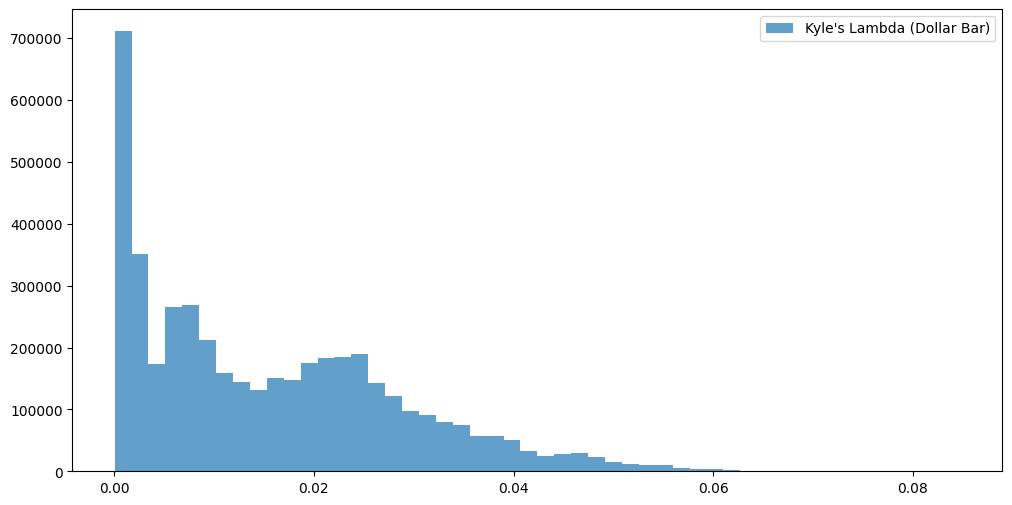

In [6]:
import statsmodels.api as sm
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed

from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import numpy as np
import statsmodels.api as sm

def get_kyles_lambda(df, tick_rules, rolling_window=100, n_jobs=-1):
    # 1. 전처리
    signed_volumn = (df['Volume'] * tick_rules).dropna()
    price_diff = df['Close'].diff().dropna()
    price_diff = price_diff[-len(signed_volumn):]  # Align
    signed_volumn = signed_volumn[-len(price_diff):]

    index_range = list(range(rolling_window, len(signed_volumn)))
    
    # 2. 단일 회귀 함수 (index만 받음)
    def compute_lambda_single(X, y, i):
        #X = signed_volumn.iloc[i - rolling_window:i]
        #y = price_diff.iloc[i - rolling_window:i]
        try:
            fit = sm.OLS(y, sm.add_constant(X)).fit()
            return i, fit.params[0]  # slope only
        except:
            return i, np.nan

    # 3. 병렬 처리
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_lambda_single)(signed_volumn.iloc[i-rolling_window:i], price_diff.iloc[i-rolling_window:i], i) for i in tqdm(index_range, desc="Rolling regression")
    )

    # 4. 결과 저장
    ret = pd.Series({signed_volumn.index[idx]: val for idx, val in results}, name="kyle_lambda")

    return ret
tick_rules = df['Close'].diff().apply(np.sign).replace(0, np.nan).ffill()
kyles_lambdas = get_kyles_lambda(df, tick_rules, rolling_window=10000)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(kyles_lambdas, bins=50, alpha=0.7, label="Kyle's Lambda (Dollar Bar)")
plt.legend()
plt.show()

(b) a timeseries of dollar bars on E-miniS&P 500 futures, where

(i) $b_t$ is the volume-weighted average of the trade signs.

(ii) $V_t$ is the sum of the volumes in that bar.

(iii) $\Delta p_t$ is the change in price between two consecutive bars.

Rolling regression: 100%|██████████| 84319/84319 [00:23<00:00, 3541.00it/s]


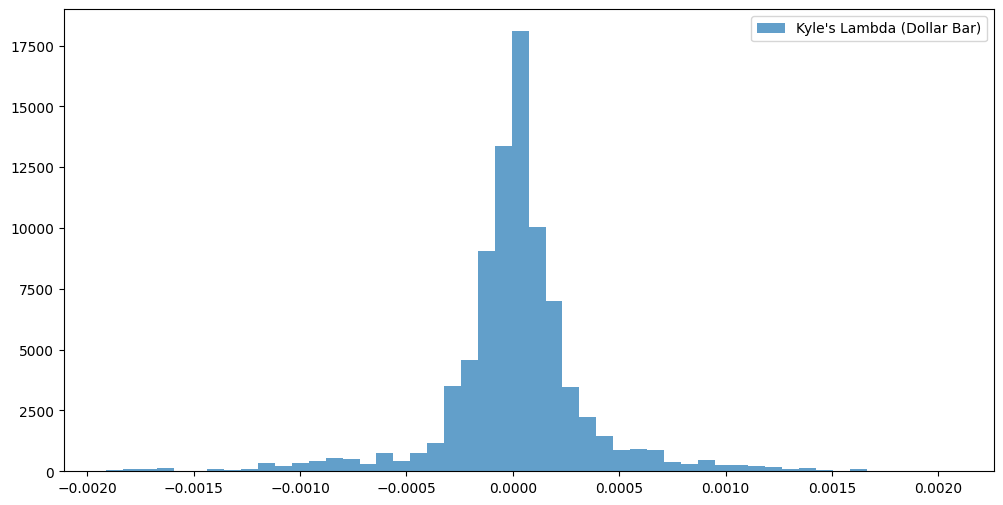

In [14]:
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import numpy as np
import statsmodels.api as sm

def get_kyles_lambda_dollar_bar(dollar_bar_df:pd.DataFrame, df:pd.DataFrame, tick_rules:pd.Series, rolling_window=100):
    signed_volume=df['Volume'] * tick_rules
    X=[]
    y=[]
    for i in range(len(dollar_bar_df)-1):
        start_index = dollar_bar_df.index[i]
        end_index = dollar_bar_df.index[i+1]
        start_index_iloc= df.index.get_loc(start_index)
        end_index_iloc = df.index.get_loc(end_index)
        if isinstance(start_index_iloc, slice) or isinstance(end_index_iloc, slice):
            start_index_iloc= start_index_iloc.start if isinstance(start_index_iloc, slice) else start_index_iloc
            end_index_iloc= end_index_iloc.start if isinstance(end_index_iloc, slice) else end_index_iloc
        bar_signed = signed_volume.iloc[start_index_iloc:end_index_iloc+1].sum()/dollar_bar_df['Volume'].iloc[i]
        bar_volume = dollar_bar_df['Volume'].iloc[i]
        bar_price_diff = dollar_bar_df['Close'].iloc[i+1] - dollar_bar_df['Close'].iloc[i]

        X.append(bar_signed* bar_volume)
        y.append(bar_price_diff)

    X = pd.Series(X, index=dollar_bar_df.index[1:]).dropna()
    y = pd.Series(y, index=dollar_bar_df.index[1:]).dropna()

    def compute_lambda_single(X, y, i):
        try:
            fit = sm.OLS(y, sm.add_constant(X)).fit()
            return i, fit.params[0]  # slope only
        except:
            return i, np.nan
        
    results= Parallel(n_jobs=-1)(
        delayed(compute_lambda_single)(X.iloc[i-rolling_window:i], y.iloc[i-rolling_window:i], i) for i in tqdm(range(rolling_window, len(X)), desc="Rolling regression")
    )

    ret = pd.Series({X.index[idx]: val for idx, val in results}, name="kyle_lambda_dollar_bar")
    ret.index.name = 'index'
    return ret

kyles_lambdas_dollar_bar = get_kyles_lambda_dollar_bar(dollar_bar_df, df, tick_rules, rolling_window=1000)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(kyles_lambdas_dollar_bar, bins=50, alpha=0.7, label="Kyle's Lambda (Dollar Bar)")
plt.legend()
plt.show()
        
        

19.6 Repeat exercise 5, this time applying Hasbrouck’s lambda.Are results consistent?

Rolling regression: 100%|██████████| 84319/84319 [00:34<00:00, 2425.99it/s]


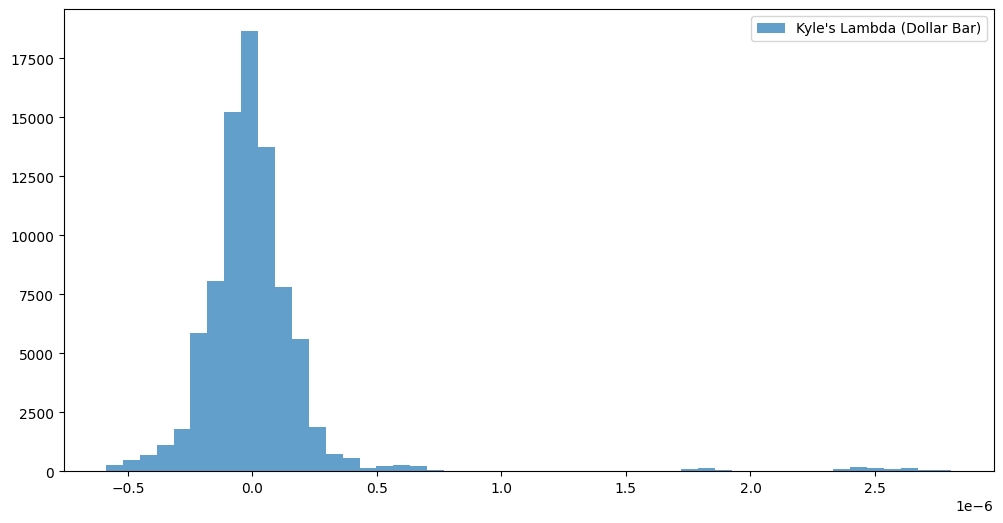

In [ ]:
def get_hasbrouck_lambda(dollar_bar_df:pd.DataFrame, df:pd.DataFrame, tick_rules:pd.Series, rolling_window=100):
    dollar_volume = df['Volume'] * df['Close']
    X = []
    y = []
    for i in range(len(dollar_bar_df)-1):
        start_index = dollar_bar_df.index[i]
        end_index = dollar_bar_df.index[i+1]
        start_index_iloc = df.index.get_loc(start_index)
        end_index_iloc = df.index.get_loc(end_index)
        if isinstance(start_index_iloc, slice) or isinstance(end_index_iloc, slice):
            start_index_iloc= start_index_iloc.start if isinstance(start_index_iloc, slice) else start_index_iloc
            end_index_iloc= end_index_iloc.start if isinstance(end_index_iloc, slice) else end_index_iloc
        cur_dollar_volume = dollar_volume.iloc[start_index_iloc:end_index_iloc+1]
        cur_tick_rules = tick_rules.iloc[start_index_iloc:start_index_iloc+1]

        X.append((cur_tick_rules*np.sqrt(cur_dollar_volume)).sum())
        y.append(np.log(dollar_bar_df['Close'].iloc[i+1] / dollar_bar_df['Close'].iloc[i]))
       

    X = pd.Series(X, index=dollar_bar_df.index[1:]).dropna()
    y = pd.Series(y, index=dollar_bar_df.index[1:]).dropna()

    results = Parallel(n_jobs=-1)(
        delayed(lambda i: (i, sm.OLS(y.iloc[i-rolling_window:i], sm.add_constant(X.iloc[i-rolling_window:i])).fit().params[0]))(i) for i in tqdm(range(rolling_window, len(X)), desc="Rolling regression")
    )

    ret = pd.Series({X.index[idx]: val for idx, val in results}, name="hasbrouck_lambda")
    ret.index.name = 'index'
    return ret


hasbrouck_lambda= get_hasbrouck_lambda(dollar_bar_df, df, tick_rules, rolling_window=1000)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(hasbrouck_lambda, bins=50, alpha=0.7, label="Hasbrouck Lambda (Dollar Bar)")
plt.legend()
plt.show()

19.7 Repeat exercise 5, this time applying Amihud’s lambda. Are results consistent?

Rolling regression:   2%|▏         | 1900/84319 [00:00<00:15, 5480.65it/s]/opt/homebrew/anaconda3/envs/AFML/lib/python3.12/site-packages/statsmodels/tsa/tsatools.py:162: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  x = pd.concat(x[::order], axis=1)
Rolling regression: 100%|██████████| 84319/84319 [00:19<00:00, 4392.74it/s]


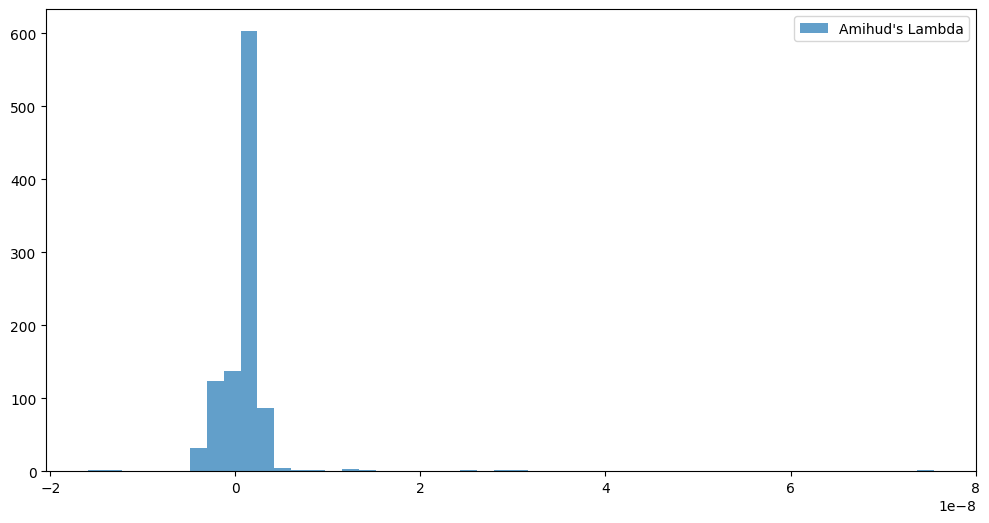

In [ ]:
def get_amihud_lambda(dollar_bar_df:pd.DataFrame, df:pd.DataFrame, rolling_window=100):
    X = []
    y = []
    dollar_volume = df['Volume'] * df['Close']
    for i in range(len(dollar_bar_df)-1):
        start_index = dollar_bar_df.index[i]
        end_index = dollar_bar_df.index[i+1]
        start_index_iloc = df.index.get_loc(start_index)
        end_index_iloc = df.index.get_loc(end_index)
        if isinstance(start_index_iloc, slice) or isinstance(end_index_iloc, slice):
            start_index_iloc= start_index_iloc.start if isinstance(start_index_iloc, slice) else start_index_iloc
            end_index_iloc= end_index_iloc.start if isinstance(end_index_iloc, slice) else end_index_iloc
        cur_dollar_volume = dollar_volume.iloc[start_index_iloc:end_index_iloc+1].sum()

        X.append(cur_dollar_volume)
        y.append(abs(np.log(dollar_bar_df['Close'].iloc[i+1] / dollar_bar_df['Close'].iloc[i])))

    X = pd.Series(X, index=dollar_bar_df.index[1:]).dropna()
    y = pd.Series(y, index=dollar_bar_df.index[1:]).dropna()

    def compute_lambda_single(X, y, i):
        try:
            fit = sm.OLS(y.iloc[i-rolling_window:i], sm.add_constant(X.iloc[i-rolling_window:i])).fit()
            return i, fit.params[0]  # slope only
        except:
            return i, np.nan
        
    results = Parallel(n_jobs=-1)(
        delayed(compute_lambda_single)(X.iloc[i-rolling_window:i], y.iloc[i-rolling_window:i], i) for i in tqdm(range(rolling_window, len(X)), desc="Rolling regression")
    )

    ret = pd.Series({X.index[idx]: val for idx, val in results}, name="amihud_lambda")
    ret.index.name = 'index'
    return ret

amihud_lambda = get_amihud_lambda(dollar_bar_df, df, rolling_window=1000)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(amihud_lambda, bins=50, alpha=0.7, label="Amihud's Lambda (Dollar Bar)")
plt.legend()
plt.show()

19.8 Form a time series of volume bars on E-miniS&P 500 futures,

In [18]:
def get_volume_bars(df: pd.DataFrame, volume_threshold: float):
    """
    Create volume bars based on a specified volume threshold.
    
    Parameters:
    df (pd.DataFrame): DataFrame with 'Volume' and 'Close' columns.
    volume_threshold (float): The volume threshold for creating bars.
    
    Returns:
    pd.DataFrame: DataFrame with volume bars.
    """
    volume = df['Volume']
    start_index = 0
    cur_sum = 0
    bar_list = []
    
    for i in range(len(volume)):
        if cur_sum + volume.iloc[i] >= volume_threshold:
            bar = {
                'Open': df['Close'].iloc[start_index],
                'High': df['Close'].iloc[start_index:i+1].max(),
                'Low': df['Close'].iloc[start_index:i+1].min(),
                'Close': df['Close'].iloc[i],
                'Volume': volume[start_index:i+1].sum(),
            }
            bar_list.append((volume.index[start_index], bar))
            start_index = i + 1
            cur_sum = 0
        else:
            cur_sum += volume.iloc[i]
    
    if cur_sum > 0 and start_index < len(volume):
        bar = {
            'Open': df['Close'].iloc[start_index],
            'High': df['Close'].iloc[start_index:i+1].max(),
            'Low': df['Close'].iloc[start_index:i+1].min(),
            'Close': df['Close'].iloc[i],
            'Volume': volume[start_index:i+1].sum(),
        }
        bar_list.append((volume.index[start_index], bar))
    
    return pd.DataFrame.from_dict(dict(bar_list), orient='index')


total_volume = np.sum(df['Volume'])
total_days = len(df.resample('D').last().dropna())  

desired_daily_bar = 100
volume = total_volume / (total_days * desired_daily_bar)

volume_bars_df = get_volume_bars(df, volume)

In [21]:
print(volume_bars_df.head())

                       Open    High     Low   Close  Volume
2006-01-02 17:00:02  1255.5  1256.5  1255.5  1256.5      41
2006-01-02 17:01:19  1256.5  1257.5  1256.5  1257.0      41
2006-01-02 17:03:59  1256.9  1257.6  1256.9  1257.2      41
2006-01-02 17:06:57  1257.2  1257.3  1257.1  1257.1      41
2006-01-02 17:10:57  1257.1  1257.1  1256.8  1257.0      41


(a) Compute the seriesof VPIN on May 6, 2010 (flash crash).

In [23]:
target_start='2010-05-05'
target_end='2010-05-07'

def get_vpin(volume_bars_df: pd.DataFrame, df: pd.DataFrame, tick_rules: pd.Series, rolling_window=100):

    vpin = pd.Series(index=volume_bars_df.index[rolling_window:], dtype=float)
    for i in range(rolling_window, len(volume_bars_df)):
        start_index = volume_bars_df.index[i-rolling_window]
        end_index = volume_bars_df.index[i]
        start_index_iloc = df.index.get_loc(start_index)
        end_index_iloc = df.index.get_loc(end_index)
        if isinstance(start_index_iloc, slice) or isinstance(end_index_iloc, slice):
            start_index_iloc= start_index_iloc.start if isinstance(start_index_iloc, slice) else start_index_iloc
            end_index_iloc= end_index_iloc.start if isinstance(end_index_iloc, slice) else end_index_iloc
        cur_volume = df['Volume'].iloc[start_index_iloc:end_index_iloc+1]
        cur_tick_rules = tick_rules.iloc[start_index_iloc:end_index_iloc+1]
        
        if len(cur_volume) == 0 or len(cur_tick_rules) == 0:
            continue
        
        bar_signed_sum=0
        total_volume=0
        for j in range(rolling_window):
            vol_bar_start= volume_bars_df.index[i-rolling_window+j]
            vol_bar_end = volume_bars_df.index[i-rolling_window+j+1] if j < rolling_window - 1 else end_index
            cur_volume = df['Volume'].loc[vol_bar_start:vol_bar_end]
            cur_tick_rules = tick_rules.loc[vol_bar_start:vol_bar_end]
            bar_signed_sum += np.abs((cur_volume * cur_tick_rules).sum())
            total_volume += cur_volume.sum()

        if total_volume == 0:
            continue

        vpin.iloc[i-rolling_window] = bar_signed_sum / total_volume
    vpin = vpin.fillna(0)
    vpin.name = 'vpin'
    vpin.index.name = 'index'
    return vpin


vpin = get_vpin(volume_bars_df.loc[target_start:target_end], df[target_start:target_end], tick_rules[target_start:target_end])
        
        

(b) Plot the series of VPIN and prices. What do you see?

5월 6일 오전~오후에 서서히 상승하여 매수 매도의 불균형이 누적되었다가, 5월 6일 늦은 오후에 급락하는 것을 확인할 수 있다.

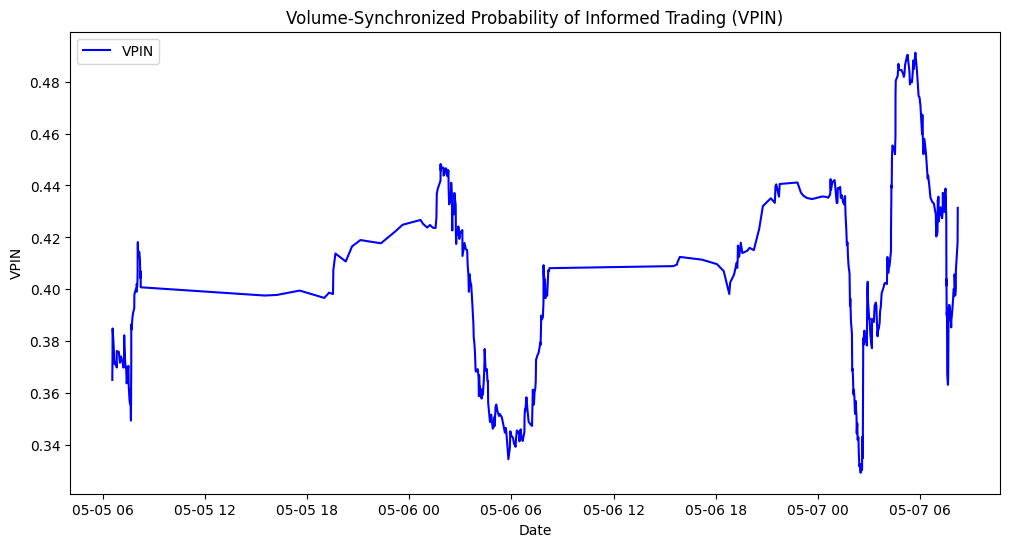

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(vpin.index, vpin, label='VPIN', color='blue')
plt.title('Volume-Synchronized Probability of Informed Trading (VPIN)')
plt.xlabel('Date')
plt.ylabel('VPIN')
plt.legend()
plt.show()

19.9 Compute the distribution of order sizes for E-mini S&P 500 futures

(a) Over the entire period.

Round size trade ratio: 2.86%


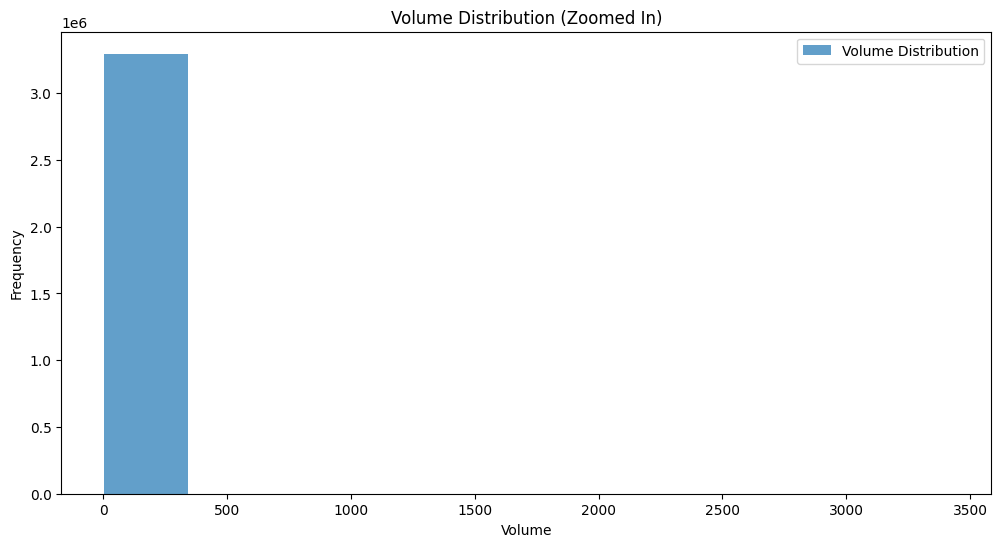

In [55]:
def is_round_number(x, round_sizes=set(i for i in range(0, max(df['Volume']), 5))):
    return x in round_sizes

target_start = df.index[0]
target_end = '2010-05-05 23:59:59'

round_size = df[df['Volume'] > 0].loc[target_start:target_end, 'Volume'].apply(is_round_number)
round_size_ratio = round_size.mean()
print(f"Round size trade ratio: {round_size_ratio:.2%}")

plt.figure(figsize=(12, 6))
plt.hist(df[df['Volume'] > 0].loc[target_start:target_end, 'Volume'], bins=10, alpha=0.7, label='Volume Distribution')
plt.title('Volume Distribution (Zoomed In)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend()
plt.show()



(b) For May 6, 2010.

Round size trade ratio: 1.61%


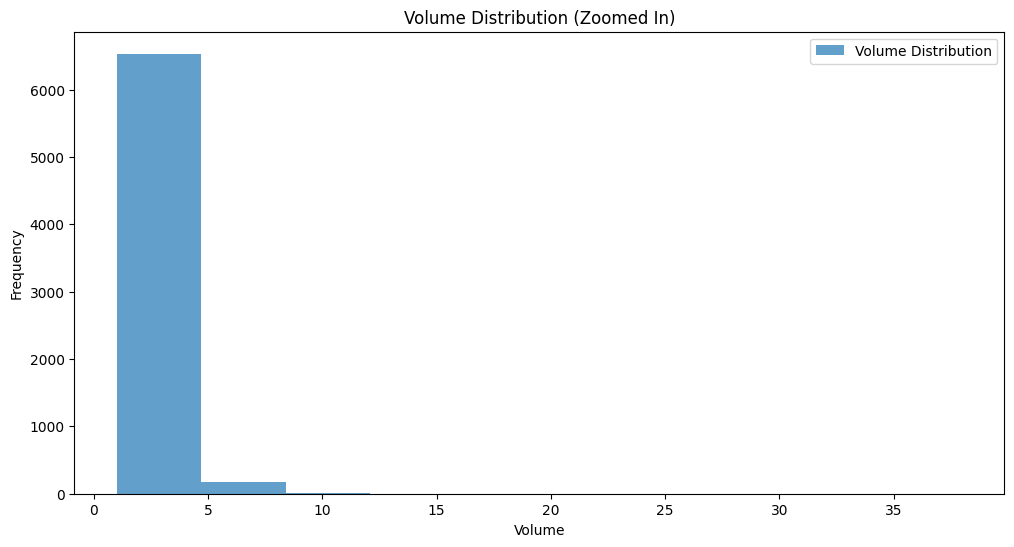

In [ ]:
def is_round_number(x, round_sizes=set(i for i in range(0, max(df['Volume']), 5))):
    return x in round_sizes

target_start = '2010-05-06 00:00:00'
target_end = '2010-05-06 23:59:59'

round_size = df[df['Volume'] > 0].loc[target_start:target_end, 'Volume'].apply(is_round_number)
round_size_ratio = round_size.mean()
print(f"Round size trade ratio: {round_size_ratio:.2%}")

plt.figure(figsize=(12, 6))
plt.hist(df[df['Volume'] > 0].loc[target_start:target_end, 'Volume'], bins=10, alpha=0.7, label='Volume Distribution')
plt.title('Volume Distribution (Zoomed In)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend()
plt.show()

(c) Conduct a Kolmogorov-Smirnov test on both distributions. Are they sig-
nificantly different, at a 95% confidence level?

19.10 Compute a time series of daily quote cancellations rates, and the portion of
market orders, on theE-mini S&P 500 futures dataset.

(a) What is the correlation between these two series? Is it statistically signif-
icant?

(b) What is the correlation between the two series and daily volatility? Is this
what you expected?

19.11 On the E-mini S&P 500 futures tickdata:

(a) Compute the distribution of volume executed with in the first 5 seconds of
every minute.

(b) Compute the distribution of volume executed every minute.

(c) Compute the Kolmogorov-Smirnov test on both distributions. Are they
significantly different, at a 95% confidence level?

19.12 On the E-mini S&P 500 futures tickdata:

(a) Compute the first-order serial correlation of signed volumes.

(b) Is it statistically significant, at a 95% confidence level?